# Laborator 12

Documentati-va depsre algoritmii de recomandare (collaborative recommendations) si, folosind un set de date de la [GroupLens](https://grouplens.org/datasets/) - exceptand MovieLens - efectuati recomandari de obiecte (carti etc.) pentru un utilizator in functie de: scorurile (rating-urile) date de utilizator si scorurile date de alti utilizatori. 

Testati cel putin 2 variante de rezolvare si comparati rezultatele obtinute. 


Bibliografie selectiva:

1. [Collaborative Filtering: A Tutorial](https://www.cs.cmu.edu/~wcohen/collab-filtering-tutorial.ppt)
1. Capitolul 2 "Making recommendations" din "Programming Collective Intelligence", Toby Segaran, O'Reilly Press, 2007
1. [Collaborative Filtering](http://www.math.univ-toulouse.fr/~besse/Wikistat/pdf/st-m-datSc3-colFil.pdf)
1. [Recommendation Using Matrix Factorization](https://medium.com/@paritosh_30025/recommendation-using-matrix-factorization-5223a8ee1f4)

Predarea temei se va face in ultimul laborator din semestru.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
import ipywidgets as widgets
from IPython.display import display, clear_output
from contextlib import contextmanager
import sklearn.metrics as metrics
import os, sys
import re


pd.set_option('display.max_colwidth', -1)

# [Book-Crossing](https://grouplens.org/datasets/book-crossing/)

## Loading Data Set

In [2]:
books = pd.read_csv('books.csv', sep=';', error_bad_lines=False, encoding='latin-1')
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

users = pd.read_csv('users.csv', sep=';', error_bad_lines=False, encoding='latin-1')
users.columns = ['userID', 'Location', 'Age']

ratings = pd.read_csv('book-ratings.csv', sep=';', error_bad_lines=False, encoding='latin-1')
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3044: Dtyp

### Books Data Set

In [3]:
''' Eliminam coloanele care nu aduc informatii utile '''

books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'], axis = 1, inplace = True)
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [4]:
books.describe()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
count,271360,271360,271359,271360,271358
unique,271360,242135,102023,202,16807
top,0373245734,Selected Poems,Agatha Christie,2002,Harlequin
freq,1,27,632,13903,7535


In [5]:
''' Observam ca anumiti ani sunt cititi gresit ('DK Publishing Inc', 'Gallimard'), corectam setul de date'''

books.yearOfPublication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [6]:
books.loc[books.yearOfPublication == 'DK Publishing Inc', :]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [7]:
books.loc[books.ISBN == '0789466953', 'yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953', 'bookAuthor'] = 'James Buckley'
books.loc[books.ISBN == '0789466953', 'publisher'] = 'DK Publishing Inc'
books.loc[books.ISBN == '0789466953', 'bookTitle'] = 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)'

In [8]:
books.loc[books.ISBN == '078946697X', 'yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X', 'bookAuthor'] = 'Michael Teitelbaum'
books.loc[books.ISBN == '078946697X', 'publisher'] = 'DK Publishing Inc'
books.loc[books.ISBN == '078946697X', 'bookTitle'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'

In [9]:
books.loc[books.yearOfPublication == 'Gallimard', :]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [10]:
books.loc[books.ISBN == '2070426769', 'yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769', 'bookAuthor'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'
books.loc[books.ISBN == '2070426769', 'publisher'] = 'Gallimard'
books.loc[books.ISBN == '2070426769', 'bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers'"

In [11]:
books.yearOfPublication = pd.to_numeric(books.yearOfPublication, errors = 'coerce')

In [12]:
print(sorted(books.yearOfPublication.unique()))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


In [13]:
''' Setul de date a fost conceput in anul 2004, asadar anumiti ani sunt posibil gresiti. Setam cu NaN anii mai mari decat 2005 
si 0 inclusiv, apoi ii inlocuim cu media anilor ramasi'''

books.loc[(books.yearOfPublication > 2005) | (books.yearOfPublication == 0), 'yearOfPublication'] = np.NaN
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()), inplace = True)
books.yearOfPublication = books.yearOfPublication.astype(np.int32)

In [14]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [15]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
ISBN                 271360 non-null object
bookTitle            271360 non-null object
bookAuthor           271359 non-null object
yearOfPublication    271360 non-null int32
publisher            271358 non-null object
dtypes: int32(1), object(4)
memory usage: 9.3+ MB


In [16]:
'''Exista o carte fara autor '''
books.loc[books.bookAuthor.isnull(), :]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Personal Wealth,NaN,1995,Edinburgh Financial Publishing


In [17]:
'''Inlocuim in coloana publisher valorile NaN cu other '''
books.loc[books.publisher.isnull(), :]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [18]:
books.loc[books.ISBN == '193169656X', 'publisher'] = 'other'
books.loc[books.ISBN == '1931696993', 'publisher'] = 'other'

### Users Data Set

In [19]:
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [20]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
userID      278858 non-null int64
Location    278858 non-null object
Age         168096 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [21]:
print(sorted(users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

In [22]:
'''Realizam aceeasi corectie ca in cazul anilor de publicatie al cartilor, astfel anii utilizatorilor mai mici decat 5 
si mai mari decat 90 vor fi corectati si implicit valorile NaN '''

users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.NaN
users.Age = users.Age.fillna(users.Age.mean())
users.Age = users.Age.astype(np.int32)

In [23]:
print(sorted(users.Age.unique()))

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


### Ratings Data Set

In [24]:
ratings.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [25]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
userID        1149780 non-null int64
ISBN          1149780 non-null object
bookRating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [26]:
'''Ratings Data Set ar trebui sa aiba userID si ISBN care se regasesc in seturile books si users '''
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]
ratings_new = ratings_new[ratings_new.userID.isin(users.userID)]

In [27]:
print('Ratings incluzand toti users & books: ', ratings.shape)
print('Ratings incluzand doar users & books din seturile de date anterioare: ', ratings_new.shape)

Ratings incluzand toti users & books:  (1149780, 3)
Ratings incluzand doar users & books din seturile de date anterioare:  (1031136, 3)


In [28]:
'''Explicit notele se vor da intre 1 si 10, implicit vom atribui o cartilor fara rating'''
ratings.bookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2], dtype=int64)

In [29]:
ratings_explicit = ratings_new[ratings_new.bookRating != 0]
ratings_implicit = ratings_new[ratings_new.bookRating == 0]

In [30]:
print(ratings_new.shape)
print(ratings_explicit.shape)
print(ratings_implicit.shape)

(1031136, 3)
(383842, 3)
(647294, 3)


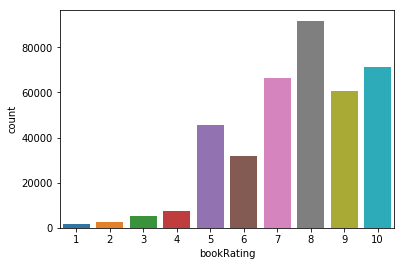

In [31]:
sns.countplot(data=ratings_explicit , x='bookRating')

## Collaborative Filtering

### First Method: Nearest Neighborhood algorithm

In [32]:
'''Fiind un set foarte mare de date, vom lua in considerare utilizatorii care au notat cel putin 100 de carti 
si cartile care au cel putin 100 de rating-uri'''

counts1 = ratings_explicit['userID'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['userID'].isin(counts1[counts1 >= 100].index)]
counts = ratings_explicit['bookRating'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['bookRating'].isin(counts[counts >= 100].index)]

In [33]:
ratings_matrix = ratings_explicit.pivot(index='userID', columns='ISBN', values='bookRating')
userID = ratings_matrix.index
ISBN = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(449, 66574)


ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = ratings_matrix.astype(np.int32)
ratings_matrix.head()

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
global metric,k
k=10
metric='cosine'

In [36]:
'''Aceasta functie gaseste k obiecte similare in functie de obiectul transmis ca parametru si matricea de rating-uri'''

def getKSimilarItems(item_id, ratings_matrix, metric = metric, k=k):
    similarities=[]
    indices=[]
    ratings=ratings_matrix.T
    loc = ratings.index.get_loc(item_id)
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)
    
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()

    return similarities,indices

In [37]:
'''Functia prezice rating-ul pentru un user si un obiect specificate'''

def predictRating(user_id, item_id, ratings, metric = metric, k=k):
    prediction= wtd_sum =0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices = getKSimilarItems(item_id, ratings)
    sum_wt = np.sum(similarities)-1
    product=1
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] != item_loc:
            product = ratings.iloc[user_loc,indices.flatten()[i]] * (similarities[i])
            wtd_sum = wtd_sum + product     
            
    prediction = int(round(wtd_sum/sum_wt))
    
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10
    
    return prediction

In [38]:

def recommendItem(user_id, ratings, metric=metric):    
    if (user_id not in ratings.index.values) or type(user_id) is not int:
        print("User id should be a valid integer from this list :\n\n {} ".format(re.sub('[\[\]]', '', np.array_str(ratings_matrix.index.values))))
    else:    
        prediction = []            
        for i in range(ratings.shape[1]):
            if (ratings[str(ratings.columns[i])][user_id] !=0):
                prediction.append(predictRating(user_id, str(ratings.columns[i]) ,ratings, metric))
            else:                    
                prediction.append(-1) #for already rated items
        
        prediction = pd.Series(prediction)
        prediction = prediction.sort_values(ascending=False)
        recommended = prediction[:10]
        for i in range(len(recommended)):
            print (i+1, books.bookTitle[recommended.index[i]])                
        

In [39]:
recommendItem(999999,ratings_matrix)

User id should be a valid integer from this list :

   2033   2110   2276   4017   4385   5582   6242   6251   6543   6575
   7286   7346   8067   8245   8681   8890  10560  11676  11993  12538
  12824  12982  13552  13850  14422  15408  15418  16634  16795  16966
  17950  19085  21014  23768  23872  23902  25409  25601  25981  26535
  26544  26583  28591  28634  29259  30276  30511  30711  30735  30810
  31315  31556  31826  32773  33145  35433  35836  35857  35859  36299
  36554  36606  36609  36836  36907  37644  37712  37950  38023  38273
  38281  39281  39467  40889  40943  43246  43910  46398  47316  48025
  48494  49144  49889  51883  52199  52350  52584  52614  52917  53220
  55187  55490  55492  56271  56399  56447  56554  56959  59172  60244
  60337  60707  63714  63956  65258  66942  67840  68555  69078  69389
  69697  70415  70594  70666  72352  73681  75591  75819  76151  76223
  76499  76626  78553  78783  78834  78973  79441  81492  81560  83287
  83637  83671  85526  85

In [40]:
recommendItem(4385, ratings_matrix)

1 My Wicked Wicked Ways
2 Fair Peril
3 Wolfpointe
4 A Nest of Ninnies
5 A Bitter Legacy
6 A Hymn Before Battle
7 Thomas the Rhymer
8 Gatherer of Clouds (Initiate Brother Duology)
9 Wege zum Ruhm: 13 Hilfestellungen fÃ¼r junge KÃ¼nstler und 1 Warnung
10 Love In Bloom's


### Second Method: Matrix Transformation

In [50]:
ratings = pd.read_csv('book-ratings.csv', sep=';', error_bad_lines=False, encoding='latin-1')
ratings.columns = ['userID', 'ISBN', 'bookRating']

ratings = pd.merge(ratings, books, on='ISBN')
columns = ['bookAuthor', 'yearOfPublication', 'publisher']
ratings = ratings.drop(columns, axis=1)
ratings.head()

ratings.dropna(axis=0, subset=['bookTitle'])

popularity_users_threshold = 200
filter_users = ratings['userID'].value_counts() > popularity_users_threshold
filter_users = filter_users[filter_users].index.tolist()

popularity_books_threshold = 200
filter_books = ratings['bookTitle'].value_counts() > popularity_books_threshold
filter_books = filter_books[filter_books].index.tolist()

df = ratings[ratings['userID'].isin(filter_users)]
df = ratings[ratings['bookTitle'].isin(filter_books)]
df.head()

,userID,ISBN,bookRating,bookTitle
62,276727,0446520802,0,The Notebook
63,278418,0446520802,0,The Notebook
64,638,0446520802,0,The Notebook
65,3363,0446520802,0,The Notebook
66,7158,0446520802,10,The Notebook


In [51]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [52]:
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",34
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",34
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",34


In [53]:
ratings.head()

,userID,ISBN,bookRating,bookTitle
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


In [54]:
ratings_explicit.head()

,userID,ISBN,bookRating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9


In [55]:
R_df = df.pivot(index = 'userID', columns ='ISBN', values = 'bookRating').fillna(0)
R_df.head()

ISBN,0001047973,0020697406,0060093102,0060094818,0060129565,0060158638,0060168013,006017322X,0060175400,0060198133,...,B00006JO6O,B00007CWQC,B00008WFXL,B00009EF82,B0000C7BNG,B0000E63CJ,B0000T6KHI,B0000VZEH8,B0001FZGPI,B0001PIOX4
userID,,,,,,,,,,,,,,,,,,,,,
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
R = R_df.values
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [57]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)

In [58]:
sigma = np.diag(sigma)

In [59]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df.head()

ISBN,0001047973,0020697406,0060093102,0060094818,0060129565,0060158638,0060168013,006017322X,0060175400,0060198133,...,B00006JO6O,B00007CWQC,B00008WFXL,B00009EF82,B0000C7BNG,B0000E63CJ,B0000T6KHI,B0000VZEH8,B0001FZGPI,B0001PIOX4
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.017940,0.010428,0.010428,0.013543,0.009822,0.011013,0.014602,0.010067,-0.017407,0.007804,...,0.010428,0.010428,0.010428,0.012540,0.010675,0.010559,0.008387,0.010261,0.010681,0.010428
4,0.011618,-0.013268,-0.013268,0.013014,-0.011687,-0.016970,-0.013029,-0.015833,0.180514,0.031509,...,-0.013268,-0.013268,-0.013268,-0.020931,-0.013478,-0.014049,-0.006699,-0.016849,-0.013699,-0.013268


In [60]:
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    user_row_number = userID - 1
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    user_data = original_ratings_df[original_ratings_df.userID == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'ISBN', right_on = 'ISBN').
                     sort_values(['bookRating'], ascending=False)
                 )    
    recommendations = (movies_df[~movies_df['ISBN'].isin(user_full['ISBN'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'ISBN',
               right_on = 'ISBN').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )
    return user_full, recommendations

already_rated, predictions = recommend_movies(preds_df, 4385, books, ratings_explicit, 10)

In [61]:
already_rated.head()

,userID,ISBN,bookRating,bookTitle,bookAuthor,yearOfPublication,publisher
0,4385,0061083402,10,The Bandit's Lady (Harper Monogram),Maureen Child,1995,Harper Mass Market Paperbacks (Mm)
129,4385,0373650396,10,In The Arms Of A Hero (Fortunes Of Texas) (The Fortunes of Texas),Wayne Barton,2000,Silhouette
131,4385,0373704070,10,"Streets Of Fire (Superomance, No 407)",Judith Duncan,1990,Harlequin
132,4385,0373705247,10,"String Of Miracles (Harlequin Superromance, No 524)",Sally Garrett,1992,Harlequin
133,4385,0373706448,10,"Finding Father (Family Man) (Harlequin Superromance, No 644)",Anne Marie Duquette,1995,Harlequin


In [62]:
predictions.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
231,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
102,0451166892,The Pillars of the Earth,Ken Follett,1996,Signet Book
38,0449005615,Seabiscuit: An American Legend,LAURA HILLENBRAND,2002,Ballantine Books
7463,0440222656,The Horse Whisperer,Nicholas Evans,1996,Dell
7510,014029628X,Girl in Hyacinth Blue,Susan Vreeland,2000,Penguin Books


In [63]:
R_df.index.values

array([     8,      9,     14, ..., 278844, 278846, 278854], dtype=int64)